# Rage Against the Machine Learning: Predicting the Next Hollywood Hit

### *Preparation and Overview (30 points total)*
**Requirement: **[5 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results.

### Overview of our Efforts
There are literally tens of thousands of movies out there today. While some do great at the box office and bring in a lot of money, others flop making only a fraction of the top hits. What if we had a scientific way of accurately predicting how much revenue a movie would generate over its lifetime? Well, through machine learning we believe that we actually can!

The dataset we are using is found on <a href="https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset">Kaggle</a>. It consists of 5000+ movies scraped from the review site IMDB. There is quite a bit of data recorded for each movie and so we had a lot to work with to try to predict the next big hit. The data was collected from web scraping IMDB using a python library called "scrappy" to collect all of the data below. The features recorded for each movie are: 

Basic Info:
- movie title
- color (black and white or color)	
- duration of the movie
- director name
- gross (total revenue)
- genres (a lits of different genres ascribed to the movie)
- number of faces in movie poster
- language of the movie
- country the movie was produced in
- content rating (G, PG, PG-13, R, NC-17)
- budget
- year of release
- aspect ratio
- name of the 3rd actor
- name of the 2nd actor
- name of the 1st actor

Facebook Info:
- number of director facebook likes
- number of facebook likes for the whole cast
- number of the movie's facebook likes
- number of the 3rd actor's facebook likes
- number of the 2nd actor's facebook likes
- number of the 1st actor's facebook likes

IMDB Specific Info:
- number of imdb users who rated the movie
- number of critical reviews for the movie
- number of users who left a review
- imdb score
- top plot keywords


With all of this data collected on so many movies, we hope to be able to use this to build out a linear regression model to accurately predict the financial success (measured in gross revenue) of a movie. We think that this could be a useful tool to anyone in the movie industry who is concerned with making a profit on their movie. It could also help a producer understand which of these features are the most important to an accurate prediction, what actors have been successful, what directors have been successful, etc.

**Requirement: ** [10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Data Mangling:

Mangling of the CSV:
- We first removed the imdb link from the csv because we knew we would never need to use that (**Note: this was the only feature removed from the csv**)
- We then went through and deleted all of the movies that were made in another country (foriegn films) we did this because we wanted to just look at American films, also because the currency units for those countries (for budget and gross) were in native currency units, not USD, and with changing exchange rates, it's not very easy to compare across countries.
- We then went through and converted all 0 values for gross, movie_facebook_likes, and director_facebook_likes to a blank value in the csv (so that it is read in as NaN by pandas), this is so that we cna more easily impute values later. Note: according to the description on the kaggle entry, because of the way the data was scraped, some movies had missing data. The Python scraper just made these values into a 0 instead of NaN.
- We then removed all movies with an undefined gross. Being the feature we are trying to predict, we should not be imputing values for gross to train our model. That will basically reduce our model to an imputation algorithm...
- We then removed all movies that were made before 1935. We did this because there were only a handful of movies ranging from 1915 to 1935, the way we are classifying budget (described below) would not work with a small sample of movies from that time period. We could have cut this number at a different year (say 1960), but we didn't want to exclude such classics as "Bambi" or "Gone With the Wind"

Mangling of the Data:
- After the above steps, we made more edits to the data using pandas. First, we removed features that we thought would be un-useful to our prediction algorithm. We removed all features concerning facebook likes. We did this because a significant portion of the movies in the training set debuted before facebook was invented and widely adopted. While some of these movies have received retroactive "likes" on facebook, only the most famous classics received a substantial amount of retraoctive "likes". Most lesser known films received very low amounts of "likes" (presumably because modern movie watchers don't really care to search for lesser known movies on facebook, or because the movie doesn't have a facebook). For this reason we decided to remove movie_facebook_likes
- Likewise, we removed the other "likes" for the same reasons as above. For example, the esteemed director George Lucas has a total of 0 "likes" between all of his films. This feature obviously would not help us predict the profitability of movies.
- We also removed irrelevant information such as aspect_ratio, language, and country. Because we deleted all foreign films the country will always be USA. A simple filter of the data reveals that there are no more than 20 movies made in the US that use a language other than English, therefore there is not enough data to use language as training feature. However, we did not delete the movies in a different language, because most of them were famous films such as *Letters from Iwo Jima* and *The Kite Runner*. We still count them as a valuable part of the dataset, just don't find the language of particular value. Lastly, we removed aspect_ratio because that seems to be unimportant for predicting the success of a movie.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("movie_data_trim.csv")
for x in ['movie_facebook_likes', 'director_facebook_likes', 'actor_2_facebook_likes', 
          'actor_1_facebook_likes','actor_3_facebook_likes', 'cast_total_facebook_likes',
          'aspect_ratio', 'language', 'country', 'plot_keywords', 'actor_3_name', 'actor_2_name', 'movie_title', 'genres', 'color']:
    if x in df:
        del df[x]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 12 columns):
director_name             3222 non-null object
num_critic_for_reviews    3219 non-null float64
duration                  3221 non-null float64
gross                     3222 non-null int64
actor_1_name              3220 non-null object
num_voted_users           3222 non-null int64
facenumber_in_poster      3216 non-null float64
num_user_for_reviews      3221 non-null float64
content_rating            3196 non-null object
budget                    3062 non-null float64
title_year                3222 non-null int64
imdb_score                3222 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 302.1+ KB
None


### Adjusting for Inflation
We need to adjust for inflation before we impute any of the values. For adjusting for inflation we obtained a csv of consumer price index (CPI) for every month since 1947. To simplify, we just took the value for January of that year to use for the whole year. We then took the CPI and calculated the ratio per year compared to 2017 dollars. This is shown below to give a sense of what inflation has looked like:

In [2]:
df_inflation = pd.read_csv("inflation_data.csv")
print(df_inflation[:10])

   DATE   VALUE
0  1947  11.367
1  1948  10.311
2  1949  10.169
3  1950  10.385
4  1951   9.620
5  1952   9.231
6  1953   9.165
7  1954   9.063
8  1955   9.121
9  1956   9.100


We then take the budget and gross and multiply them out with their appropriate ratio value. In this way everything is converted to 2017 dollars USD.

In [3]:
%%time
for x in range(0, len(df)):
    adjusted = list(np.where(df_inflation["DATE"] == df['title_year'][x])[0])
    adjusted = df_inflation.iloc[adjusted]['VALUE'].values[0]
    df['gross'][x] = df['gross'][x] * adjusted 
    df['budget'][x] = df['budget'][x] * adjusted


D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Wall time: 2min 5s


In [4]:
# Tamper with the groupings to improve imputations? How do we improve how many values get imputed?
df_grouped = df.groupby(by=['director_name'])
# director_name adds about 50 rows (imputes about 50 rows and then deletes about 100)

In [5]:
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
col_deleted = list( set(df.columns) - set(df_imputed.columns)) #in case the median op deleted columns
df_imputed[col_deleted] = df[col_deleted]

# drop rows that still have missing values after imputation
df_imputed.dropna(inplace=True)
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3220
Data columns (total 12 columns):
num_critic_for_reviews    3127 non-null float64
duration                  3127 non-null float64
gross                     3127 non-null int64
num_voted_users           3127 non-null int64
facenumber_in_poster      3127 non-null float64
num_user_for_reviews      3127 non-null float64
budget                    3127 non-null float64
title_year                3127 non-null int64
imdb_score                3127 non-null float64
content_rating            3127 non-null object
director_name             3127 non-null object
actor_1_name              3127 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 317.6+ KB
None


In [6]:
%%time
#scaling budgets!
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 200)



budget = df_imputed['budget'].values.reshape(-1, 1)
df_imputed.reset_index(drop=True, inplace=True)
print("df: ",df_imputed.shape)

append_list = [df_imputed]

budget_scaler = StandardScaler()
append_list.append(pd.DataFrame(budget_scaler.fit_transform(budget), columns=['scaled_budget']))

gross = df_imputed['gross'].values.reshape(-1,1)
gross_scaler = StandardScaler()
append_list.append(pd.DataFrame(gross_scaler.fit_transform(gross), columns=['scaled_gross']))

critics = df_imputed['num_critic_for_reviews'].values.reshape(-1, 1)
critic_scaler = StandardScaler()
append_list.append(pd.DataFrame(critic_scaler.fit_transform(critics), columns=['scaled_critics']))
# print(df)

duration = df_imputed['duration'].values.reshape(-1, 1)
duration_scaler = StandardScaler()
append_list.append(pd.DataFrame(duration_scaler.fit_transform(duration), columns=['scaled_duration']))
         
num_voted_users = df_imputed['num_voted_users'].values.reshape(-1, 1)
voted_scaler = StandardScaler()
append_list.append(pd.DataFrame(voted_scaler.fit_transform(num_voted_users), columns=['scaled_voted_users']))

num_user_for_reviews = df_imputed['num_user_for_reviews'].values.reshape(-1,1)
user_reviews_scaler = StandardScaler()
append_list.append(pd.DataFrame(user_reviews_scaler.fit_transform(num_user_for_reviews), columns=['scaled_user_reviews']))

df = pd.concat(append_list, axis=1)

#one-hot encode
# hot_director = pd.get_dummies(df_imputed.director_name, prefix='directorName')
hot_content = pd.get_dummies(df_imputed.content_rating, prefix='contentRating')
# hot_actor = pd.get_dummies(df_imputed.actor_1_name, prefix='actorName')
# df = pd.concat([df, hot_director, hot_content, hot_actor], axis=1)

print(df.shape)

df:  (3127, 12)
(3127, 18)
Wall time: 322 ms


D:\Programming\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
from sklearn.preprocessing import LabelEncoder

spacing = np.linspace(0, max(df['gross']), 100)
labels = []

labels = ["low", "low-mid", "high-mid", "high"]
df['gross_group'] = pd.qcut(df['gross'], 4, labels=labels)


rating_group = df['gross_group'].values
rating_encoder = LabelEncoder()
rating_df = pd.DataFrame(rating_encoder.fit_transform(rating_group), columns=['encoded_gross']).astype(str)
df = pd.concat([df, rating_df], axis=1)


**Requirement: ** [15 points] Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue for or against splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  

### Split Up the Data Now

In [8]:
from sklearn import model_selection
train_set, test_set = model_selection.train_test_split(df, test_size=0.2, train_size=0.8, random_state= 101)
print(len(train_set), len(test_set))
## http://localhost:8888/notebooks/fork/MachineLearningNotebooks/05.%20Logistic%20Regression.ipynb#Training-and-Testing-Split

2501 626


### *Modeling (50 points total)*

___

# But First... A Super Cool Custom Regression 

**Requirement**: [20 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template used in the course. You should add the following functionality to the logistic regression classifier:

In [9]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit

def regularize(regularization, gradient, w, C):
    if(regularization == 'l2'):
        gradient[1:] += -2 * w[1:] * C
    elif(regularization == 'l1'):
        gradient[1:] += np.sign(w[1:]) * C
    elif(regularization =='l1/l2'):
        gradient[1:] += -2 * w[1:] * C
        gradient[1:] += np.sign(w[1:]) * C

    return gradient


In [10]:
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, regularization='none'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg = regularization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        gradient = regularize(self.reg, gradient, self.w_, self.C)
#         gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

In [11]:
class StochasticBinaryLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
#         gradient[1:] += -2 * self.w_[1:] * self.C
        regularize(self.reg, gradient, self.w_, self.C)
        
        return gradient

In [12]:
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient = regularize(self.reg, gradient, self.w_, self.C)
#         gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient

In [13]:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C,reg):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C,reg):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient = regularize(reg, gradient, w, C)
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C, self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

In [14]:
class LogisticRegression:
    def __init__(self, eta, iters=20, C=0.001, optimizer="steep_desc", regularization="none"):
        self.eta = eta
        self.iters = iters
        self.C = C
        self.optimizer = optimizer
        self.reg = regularization  
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            if self.optimizer == "steep_desc":
                blr = BinaryLogisticRegression(self.eta, self.iters, self.C, self.reg) #??
            elif self.optimizer == "stoch_grad":
                blr = StochasticBinaryLogisticRegression(self.eta, self.iters, self.C, self.reg)
            elif self.optimizer == "hessian":
                blr = HessianBinaryLogisticRegression(self.eta, self.iters, self.C, self.reg)
            elif self.optimizer == "bfgs":
                blr = BFGSBinaryLogisticRegression(self.eta, self.iters, self.C, self.reg)
                
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr.fit(X,y_binary)
            #print(accuracy(y_binary,bin_class.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T    
       
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier  ##go through the list of classifiers and get predictions for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(yhat.astype(int), y.astype(int))
    def set_params(self, eta=.1, iters=20, C=0.001, optimizer="steep_desc", regularization="none"):
        self.eta = eta
        self.iters = iters
        self.optimizer = optimizer
        self.reg = regularization
        return self
    def get_params(self, deep=True):
        params = {'eta': self.eta,
                 'iters': self.iters,
                 'C': self.C,
                 'optimizer': self.optimizer,
                 'regularization': self.reg}
        if deep:
            return copy.deepcopy(params)
        else:
            return params

_____
**Requirement**: Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. 

In [15]:
%%time
#Linear Regression Testing
ds = load_iris()
X = ds.data
y = ds.target # note problem is NOT binary anymore, there are three classes!
# y = (ds.target>1).astype(np.int) # make problem binary

blr = BFGSBinaryLogisticRegression(0.1, 1000, C=.001, regularization='l2')
blr.fit(X,y)
print(blr)
yhat = blr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat)) 

print("--------------------")

lr = LogisticRegression(0.1, 1000, C=0.001, optimizer="stoch_grad", regularization='l2')
lr.fit(X,y)
print(lr)
yhat = lr.predict(X)

print(y)
print('Accuracy of: ',accuracy_score(y,yhat))


Binary Logistic Regression Object with coefficients:
[[-0.31651999]
 [-0.32616006]
 [-1.35771834]
 [ 2.77188848]
 [ 1.38343114]]
Accuracy of:  0.666666666667
--------------------
MultiClass Logistic Regression Object with coefficients:
[[ 0.3665268   0.45764146  1.66711003 -2.66564025 -1.22258429]
 [ 0.86998265  0.92528415 -2.5244257   1.20380727 -1.81529627]
 [-1.51973103 -2.54211859 -2.15072697  3.99826184  3.78947085]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Accuracy of:  0.96
Wall time: 59.4 ms


In [16]:
%%time
drop_list = ['scaled_gross', 'num_critic_for_reviews', 'encoded_gross', 'gross_group', 
              'gross', 'budget', 'director_name', 'actor_1_name', 'content_rating', 'duration',
            'num_voted_users', 'num_user_for_reviews']
# with one hot encoding
X = train_set.drop(drop_list, axis=1)
y = train_set['encoded_gross'].values
X_test = test_set.drop(drop_list, axis=1)
y_test = test_set['encoded_gross'].values


Wall time: 2 ms


In [17]:
%%time
from sklearn.linear_model import LogisticRegression as sklr
from sklearn import metrics as mt

lr_sk = sklr(solver='lbfgs') 

lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
yhat = lr_sk.predict(X_test)
print(pd.Series(yhat).value_counts())
print(pd.Series(y_test).value_counts())

print('Accuracy of: ',accuracy_score(y_test,yhat))

2    211
0    184
3    139
1     92
dtype: int64
3    164
1    157
2    155
0    150
dtype: int64
Accuracy of:  0.503194888179
Wall time: 338 ms


In [18]:
%%time
clist = []
tlr = LogisticRegression(0.1, 3000, C=.001, optimizer="stoch_grad", regularization="l2")
# print(y)
tlr.fit(X, y)
# print(X)
yhat = tlr.predict(X_test)
print(pd.Series(y_test).value_counts())
print(pd.Series(yhat).value_counts())
print('Accuracy of: ',accuracy_score(y_test.astype(int),yhat.astype(int)))

3    164
1    157
2    155
0    150
dtype: int64
2    626
dtype: int64
Accuracy of:  0.247603833866
Wall time: 297 ms


In [19]:
%%time
stoch_list = []
stoch_confusion = []
x_values = np.logspace(-3,1, num=25)
x_values.sort()
for i in x_values:
    tlr = LogisticRegression(0.1, 2000, C=i, optimizer="stoch_grad", regularization="l2")

    # print(y)
    tlr.fit(X, y)
    yhat = tlr.predict(X)
#     print(train_set.encoded_rating.value_counts())
#     print(pd.Series(y).value_counts())
#     print(pd.Series(yhat).value_counts())
    stoch_confusion.append(mt.confusion_matrix(y.astype(int), yhat.astype(int)))
    stoch_list.append(accuracy_score(y.astype(int),yhat.astype(int)))
#     print('Accuracy of: ',accuracy_score(y,yhat))


Wall time: 3.62 s


In [20]:
%%time
bfgs_list = []
bfgs_confusion = []
for i in x_values:
    tlr = LogisticRegression(0.1, 50, C=i, optimizer="bfgs", regularization="l2")
    tlr.fit(X, y)
    yhat = tlr.predict(X)
    #     print(train_set.encoded_rating.value_counts())
#     print(pd.Series(y).value_counts())
#     print(pd.Series(yhat).value_counts())
#     print('Accuracy of: ',accuracy_score(y.astype(int),yhat.astype(int)))
    bfgs_confusion.append(mt.confusion_matrix(y.astype(int), yhat.astype(int)))
    bfgs_list.append(accuracy_score(y.astype(int),yhat.astype(int)))

D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:

Wall time: 2.56 s


D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:

In [21]:
%%time
hessian_list = []
hessian_confusion = []
for i in x_values:
    tlr = LogisticRegression(0.1, 20, C=i, optimizer="hessian", regularization="l2")
    tlr.fit(X, y)
    yhat = tlr.predict(X)
    #     print(train_set.encoded_rating.value_counts())
#     print(pd.Series(y).value_counts())
#     print(pd.Series(yhat).value_counts())
#     print('Accuracy of: ',accuracy_score(y.astype(int),yhat.astype(int)))
    hessian_confusion.append(mt.confusion_matrix(y.astype(int), yhat.astype(int)))
    hessian_list.append(accuracy_score(y.astype(int),yhat.astype(int)))

Wall time: 30 s


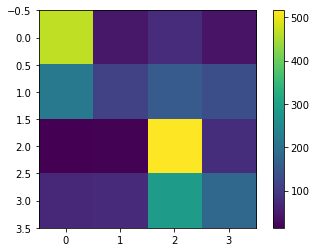

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(hessian_confusion[8])
plt.colorbar()

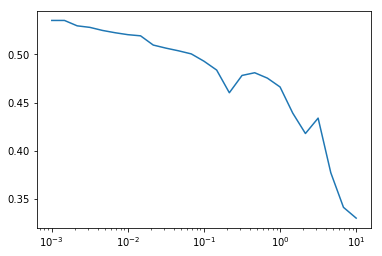

In [23]:

ax=plt.subplot(111)
# plt.plot(x_values, stoch_list, x_values, bfgs_list, x_values, hessian_list)
plt.plot(x_values, bfgs_list)
# plt.plot(x_values, hessian_list)
ax.set_xscale('log')


**Requirement: ** Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1/L2 norm of the weights). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

**Requirement: ** [15 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

**Requirement: ** [15 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time, training iterations, and memory usage while training. Discuss the results.

### *Deployment (10 points total)*
**Requirement: **Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

### *Exceptional Work (10 points total)*
**Rerquirement: ** You have free reign to provide additional analyses.
One idea: Make your implementation of logistic regression compatible with the GridSearchCV function that is part of scikit-learn.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

estimator = LogisticRegression(0.1, 100, C=.001, optimizer="bfgs", regularization="l2")
params = {'optimizer': ['bfgs', 'stoch_grad', 'hessian'],
         'regularization': ['l1', 'l2', 'l1/l2'],
         'C': np.logspace(-3, 1, num=20)}
gscv = GridSearchCV(estimator, params, scoring="accuracy", refit=False)


In [ ]:
%%time
gscv.fit(X, y)

D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\Programming\Anaconda\lib\site-packages\ipykernel\__main__.py:

In [ ]:
gscv.best_params_